In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import tensorflow_datasets as tfds

from tqdm import tqdm
from einops import rearrange
from sklearn.metrics import auc

In [90]:
from modules import *
from utils import *
from training import *
from position_encoding import TrainablePositionEncoding

# Dataset

In [3]:
#disable tensorflow from accessing the GPU - it is only processing the dataset
disable_gpu_tf()

In [57]:
dpi = 100

In [4]:
#load the dataset
dataset = "cardiotox"
n_batch = 64
ds = tfds.load(dataset, data_dir = "~/data", split="train", batch_size=n_batch)
ds_val = tfds.load(dataset, data_dir = "~/data", split="validation", batch_size=n_batch)
ds_test = tfds.load(dataset, data_dir = "~/data", split="test", batch_size=n_batch)
ds_test2 = tfds.load(dataset, data_dir = "~/data", split="test2", batch_size=n_batch)

In [5]:
full_ds = tfds.as_numpy(tfds.load(dataset, data_dir = "~/data", split="train", batch_size=-1))
full_ds_val = tfds.as_numpy(tfds.load(dataset, data_dir = "~/data", split="validation", batch_size=-1))
full_ds_test = tfds.as_numpy(tfds.load(dataset, data_dir = "~/data", split="test", batch_size=-1))
full_ds_test2 = tfds.as_numpy(tfds.load(dataset, data_dir = "~/data", split="test2", batch_size=-1))

In [6]:
#calculate the maximum number of edges over each dataset to make sure each graph fits inside the common size for batching

In [7]:
max_edges = lambda x: np.max(np.sum(x['pair_mask'].reshape(x['active'].shape[0], -1), axis=(1))) / 2

In [8]:
datasets = [full_ds, full_ds_val, full_ds_test, full_ds_test2]

In [9]:
max_edge_count = list(map(max_edges, datasets))

In [10]:
n_edge_max = int(np.max(max_edge_count) + 2)

# Graph - VSA Encoding

In [11]:
#set the dimension of the VSA
dim_vsa = 1024

In [12]:
#declare the graph encoder
g_enc = hk.transform(lambda x: GraphEncoder(dim_vsa = dim_vsa, max_edges = n_edge_max)(x))

In [13]:
#create a random key
key = random.PRNGKey(42)

In [14]:
#obtain a sample from the dataset
s = next(iter(ds))

In [15]:
#initiate the parameters for the projection
proj_params = g_enc.init(key, s)

In [16]:
test_s = g_enc.apply(proj_params, key, s)

In [25]:
make_graphs = lambda ds, sk: jnp.concatenate([g_enc.apply(proj_params, sk, s) for s in iter(tqdm(ds))])

In [28]:
#set to true if parameters and encoded data has already been run and saved on disk
load_from_disk = False

In [26]:
if not load_from_disk:
    #generate the dataset as vector-symbols
    key, sk1, sk2, sk3, sk4 = random.split(key, 5)

    all_graphs_train = make_graphs(ds, sk1)
    all_graphs_iid = make_graphs(ds_val, sk2)
    all_graphs_test = make_graphs(ds_test, sk3)
    all_graphs_test2 = make_graphs(ds_test2, sk4)
    
    print("Saving...")
    #save the converted graphs to disk to save time later if we need to re-load
    np.savez_compressed("encoded_graphs.npz", graphs=all_graphs_train)
    np.savez_compressed("encoded_graphs_iid.npz", graphs=all_graphs_iid)
    np.savez_compressed("encoded_graphs_test.npz", graphs=all_graphs_test)
    np.savez_compressed("encoded_graphs_test2.npz", graphs=all_graphs_test2)
    print("Done")
    

100%|███████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


In [31]:
if load_from_disk:
    #load datasets from disk
    print("Loading dataset from disk...")
    all_graphs_train = np.load("encoded_graphs.npz")['graphs']
    all_graphs_iid = np.load("encoded_graphs_iid.npz")['graphs']
    all_graphs_test = np.load("encoded_graphs_test.npz")['graphs']
    all_graphs_test2 = np.load("encoded_graphs_test2.npz")['graphs']
    print("Done")

# Classification Model

In [42]:
#define a self-attentional graph model

def graph_prediction_SA(x, 
                   is_training: bool = False,
                   var_scaling: float = 1.0, 
                   codebook_sparsity: float = 0.0):
    
    #convert graph to VSA
    x = jnp.array(x)
    vsa_dimension = x.shape[-1]
    
    #Compute self-attention over the inputs
    # (b x d) x (b x d) -> (b x d)
    x = SelfAttention(num_heads = 1, widening_factor=1)(x, is_training=is_training)
    
    # Flatten (x d) for final linear layer
    x = rearrange(x, "b x d -> b (x d)")
    # Merge the priors to produce a single symbol - (b x*d) -> (b d)
    x = conv_1d(vsa_dimension)(x)
    # Compute the similarity between the final symbol and the class codebook
    x = CodebookDecoder(2, vsa_dimension, sparsity=codebook_sparsity)(x)
     
    return x

In [33]:
def graph_dataset(graphs, 
                  truth, 
                  n_batch: int = 128,
                  shuffle: bool = False, 
                  repeat: bool = True):
    """
    Dataset formatter for VSA graphs
    """
        
    ds = tf.data.Dataset.from_tensor_slices((graphs, truth))
    
    if shuffle:
        #use full buffer
        n_buffer = truth.shape[0]
        ds = ds.shuffle(n_buffer)
        
    if repeat:
        ds = ds.repeat()
        
    if n_batch > 0:
        ds = ds.batch(n_batch)
    
    return ds

In [35]:
#format the datasets into batched loaders for GPU

In [36]:
train_ds = graph_dataset(all_graphs_train, 
                                    full_ds['active'],
                                    n_batch = n_batch,
                                    shuffle = True,
                                    repeat = True)

In [37]:
test_iid = graph_dataset(all_graphs_iid, 
                            full_ds_val['active'],
                            n_batch = n_batch,
                            shuffle = False,
                            repeat = False)

In [38]:
test_ds = graph_dataset(all_graphs_test, 
                            full_ds_test['active'],
                            n_batch = n_batch,
                            shuffle = False,
                            repeat = False)

In [39]:
test_ds2 = graph_dataset(all_graphs_test2, 
                            full_ds_test2['active'],
                            n_batch = n_batch,
                            shuffle = False,
                            repeat = False)

# Training Methods

In [62]:
#create an instance of the RMSprop optimizer
opt = optax.rmsprop(0.001)

In [63]:
def update_params(model: hk.Transformed, 
                key,
                trainable_params: hk.Params = None, 
                non_trainable_params: hk.Params = None, 
                loss_fn = None, 
                data = None, 
                optimizer = None, 
                opt_state = None, ):
    """
    Training loop update step. 
    """

    #lambda function to compute loss 
    batch_loss = lambda tp, ntp: jnp.mean(loss_fn(
                                        model.apply(hk.data_structures.merge(tp, ntp), key, data[0], is_training=True),
                                        jnp.array(data[1])))

    #compute the loss value and gradients
    loss_value = batch_loss(trainable_params, non_trainable_params)
    gradients = jax.grad(batch_loss)(trainable_params, non_trainable_params)
    
    #compute trainable parameter updates using the optimizer
    updates, opt_state = optimizer.update(gradients, opt_state)
    new_trainable_params = optax.apply_updates(trainable_params, updates)
    
    return new_trainable_params, opt_state, loss_value

In [64]:
def train_model(model, 
                key,
                params = None,
                optimizer = None,
                dataset = None,
                loss_fn = None,
                batches: int = None,
                loss_history = None,
                opt_state = None,
                non_trainable_params = ["codebook", "static_projection", "classification_query"]):
    """
    Main training loop for reducing loss for a model on a dataset.
    """

    #separate the trainable and non-trainable model parameters - non-trainable parameters are passed
    # via the non_trainable_params arg above
    trainable_params, non_trainable_params = hk.data_structures.partition(
        #return false for each of the non-trainable parameters in the model
        lambda m, n, v: bool(reduce(lambda a,b: a*b, [name not in m for name in non_trainable_params])),
        params
    )

    #if there is no loss history to append to (first run)
    if loss_history == None:
        loss_history = []

    #if there is no previous optimizer state (first run or stateless optimizer)
    if opt_state == None:
        opt_state = optimizer.init(trainable_params)

        
    #lambda calls parameters, batch, and optimizer state
    update_fn = lambda train_params, nontrain_params, batch, opt_state: update_params(
                            model, 
                            key, 
                            trainable_params = train_params, 
                            non_trainable_params = nontrain_params, 
                            loss_fn = loss_fn, 
                            data = batch, 
                            optimizer = optimizer, 
                            opt_state = opt_state, )

    #main optimizer loop
    for i in tqdm(range(batches)):
        batch = next(dataset)
        #call the update lambda
        trainable_params, opt_state, loss_val = update_fn(trainable_params, 
                                                    non_trainable_params, 
                                                    batch, 
                                                    opt_state)

        #append the loss value
        loss_history.append(loss_val)

    #merge the parameters back together
    new_params = hk.data_structures.merge(trainable_params, non_trainable_params)

    return new_params, loss_history

# Self-Attention Model

In [44]:
x = hk.transform(graph_prediction_SA)

In [46]:
sample = next(iter(train_ds))

In [47]:
key, subkey = random.split(key)

In [48]:
params = x.init(subkey, sample[0])

/home/wolin/anaconda3/envs/jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3729: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "ones")


In [49]:
sample_output = x.apply(params, key, sample[0])

Text(0, 0.5, 'Count')

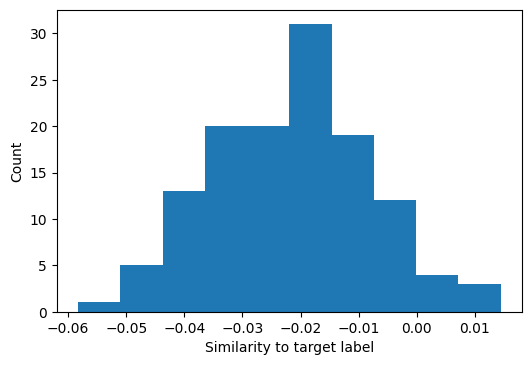

In [58]:
#show a sample of the similarities pre-training
plt.figure(dpi=dpi)
plt.hist(np.array(sample_output).ravel())
plt.xlabel("Similarity to target label")
plt.ylabel("Count")

In [54]:
def loss_fn(similarities, activity):
    loss = 1 - jnp.sum(similarities * jnp.array(activity), axis=1)
    return loss

Text(0, 0.5, 'Count')

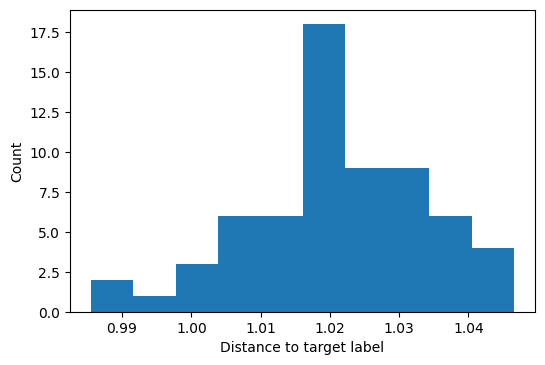

In [59]:
#show a sample of the loss pre-training
plt.figure(dpi=dpi)
plt.hist(np.array(loss_fn(sample_output, sample[1])))
plt.xlabel("Distance to target label")
plt.ylabel("Count")

In [52]:
loss_fn(sample_output, sample[1])

DeviceArray([1.018733  , 1.0438799 , 1.019621  , 1.0186331 , 1.0162113 ,
             0.9855432 , 0.98792005, 1.0100583 , 1.0274632 , 1.0194033 ,
             1.0087949 , 1.0324069 , 1.0200412 , 1.0358757 , 1.015871  ,
             1.0168223 , 1.0426254 , 1.0010282 , 1.0188382 , 1.0125252 ,
             1.0319207 , 1.0123369 , 1.0259492 , 1.0284038 , 1.0106409 ,
             1.0201662 , 1.0082434 , 1.043303  , 1.0009282 , 1.0287162 ,
             1.0320282 , 1.0351351 , 1.0154408 , 1.0312668 , 1.0253582 ,
             1.0252591 , 1.0333996 , 1.0182245 , 1.0275447 , 1.0093611 ,
             1.0207434 , 1.0399216 , 1.0288608 , 1.0189333 , 1.0371262 ,
             1.0182413 , 1.0088494 , 1.0170585 , 1.0465561 , 1.0402837 ,
             1.0199778 , 1.0225652 , 1.017766  , 1.0238438 , 1.0087085 ,
             0.9976434 , 1.0351636 , 1.0069106 , 1.0176741 , 1.0308902 ,
             1.0169415 , 0.99984515, 1.0236925 , 1.0244025 ],            dtype=float32)

In [65]:
#train the model on the dataset
params_t_SA, losses = train_model(x, 
                               key, 
                               params = params, 
                               dataset = iter(train_ds), 
                               optimizer = opt, 
                               loss_fn = loss_fn, 
                               batches = 2000,
                              non_trainable_params=["codebook", "static_projection", "classification_query"])

14it [32:33, 139.54s/it]                               | 137/2000 [00:36<05:38,  5.50it/s]
100%|█████████████████████████████████████████████████| 2000/2000 [06:21<00:00,  5.25it/s]


Text(0.5, 0, 'Batch')

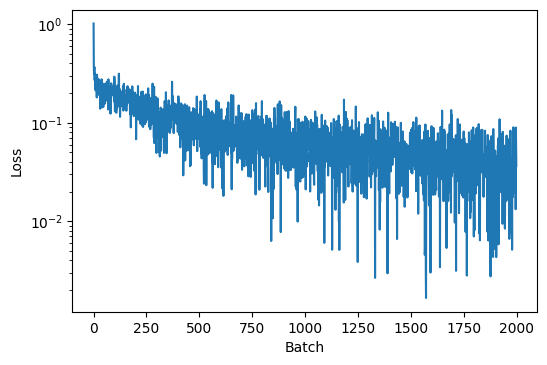

In [66]:
plt.figure(dpi=dpi)
plt.semilogy(losses)
plt.ylabel("Loss")
plt.xlabel("Batch")

In [67]:
np.savez_compressed("cardiotox_params_sa.npz", params=params_t_SA)

In [70]:
get_predictions = lambda ds: jnp.concatenate([x.apply(params_t_SA, key, s[0]) for s in iter(ds)])

In [71]:
all_test_iid = get_predictions(test_iid)
all_test_ds = get_predictions(test_ds)
all_test_ds2 = get_predictions(test_ds2)

In [72]:
b_test_iid = calc_boundary(all_test_iid)
b_test_ds = calc_boundary(all_test_ds)
b_test_ds2 = calc_boundary(all_test_ds2)

In [76]:
roc_iid = calc_roc(b_test_iid, jnp.array(full_ds_val['active']))
roc_test = calc_roc(b_test_ds, jnp.array(full_ds_test['active']))
roc_test2 = calc_roc(b_test_ds2, jnp.array(full_ds_test2['active']))

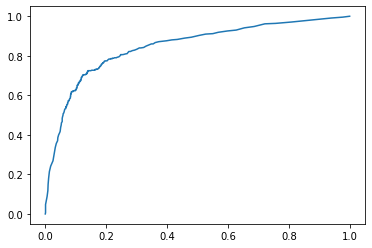

In [74]:
plt.plot(roc_iid[0], roc_iid[1])

In [77]:
auc_fn = lambda x: auc(x[0], x[1])

In [79]:
all_auc = list(map(auc_fn, [roc_iid, roc_test, roc_test2]))

In [80]:
all_auc

[0.8463586430103314, 0.732908449310256, 0.695061753317713]

Text(0.5, 1.0, 'ROC')

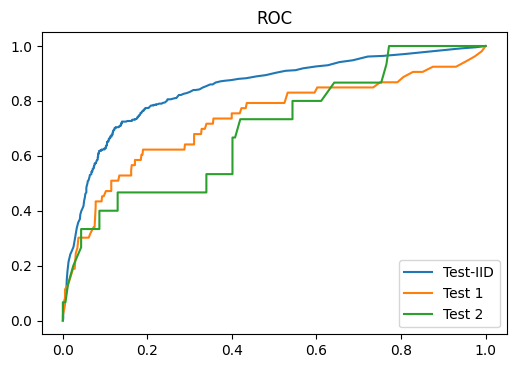

In [85]:
plt.figure(dpi=dpi)
plt.plot(roc_iid[0], roc_iid[1], label="Test-IID")
plt.plot(roc_test[0], roc_test[1], label="Test 1")
plt.plot(roc_test2[0], roc_test2[1], label="Test 2")
plt.legend(loc="lower right")
plt.title("ROC")